# Script to Predict ZooPlankton Biomass with ADCP Gliders

In [1]:
#import standard packages
import datetime
from datetime import date
import logging
import os
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser, Namespace
from functools import reduce
import glob
import matplotlib.patches as patches
import calendar

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import dask.dataframe as dd
import tqdm

#import spatial packages
import geopandas as gpd
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.category import UnitData
import numpy as np
import pandas as pd
import rioxarray as rio
import seaborn as sns
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from dask.distributed import Client
import flox.xarray
from matplotlib.lines import Line2D

#import statistical packages
from scipy.stats import linregress
from shapely.geometry import Point, mapping
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

#import spatial packages
import geopandas as gpd
# gpd.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
import shapely 
import rioxarray as rio
from shapely.geometry import mapping
from shapely.geometry import Point, LineString

#import statistical libraries
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#time packages
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime, timezone
from dateutil import tz
abc = tz.gettz('US/Pacific') #set default time zone

import warnings
warnings.filterwarnings('ignore')

## Test Different Spatial and Temporal Scales

Spatial scales (radius): 
* 1 km
* 5 km
* 10 km
* 20 km

Temporal sacles: 
* 1 day
* 7 days
* 30 days

  0%|                                                   | 0/5 [00:00<?, ?it/s]

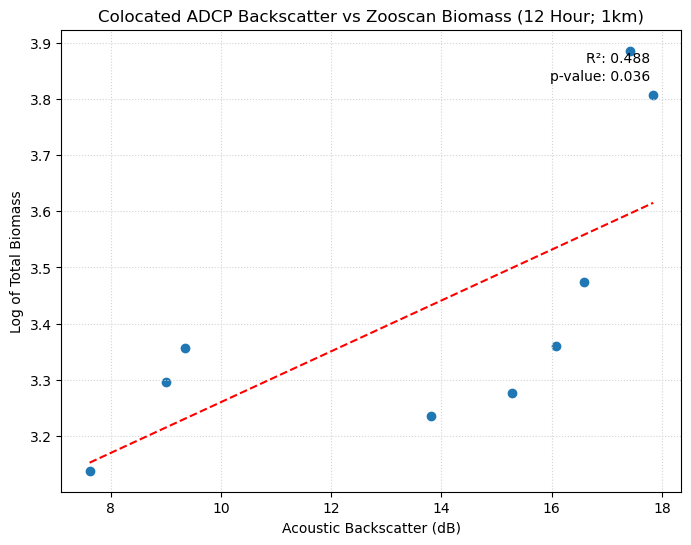

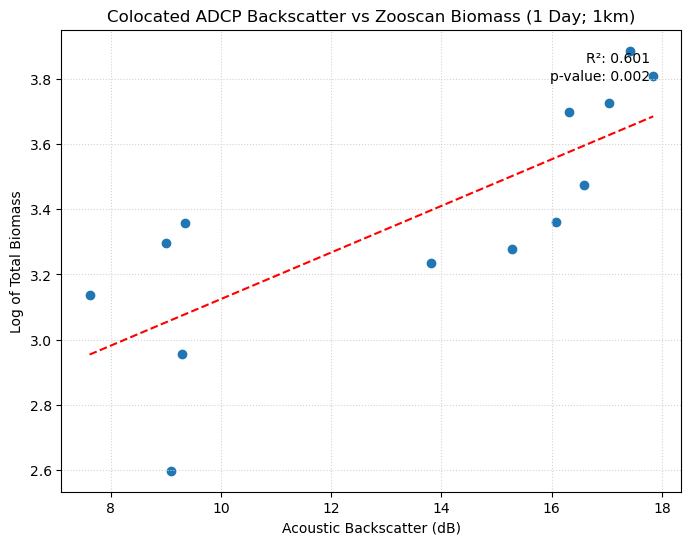

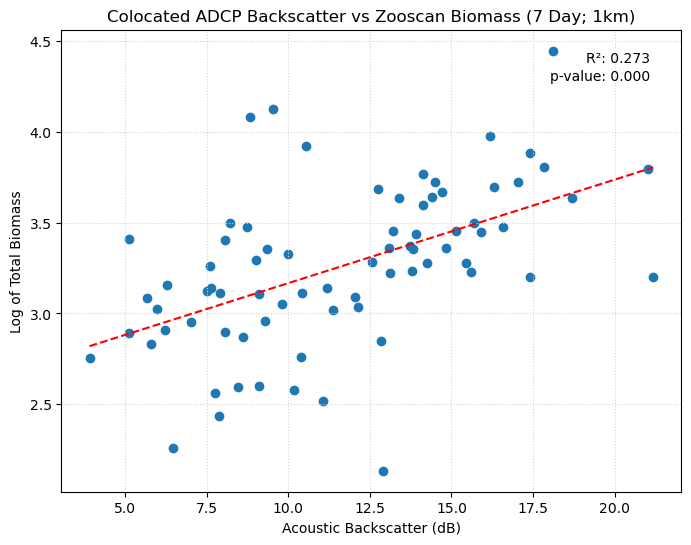

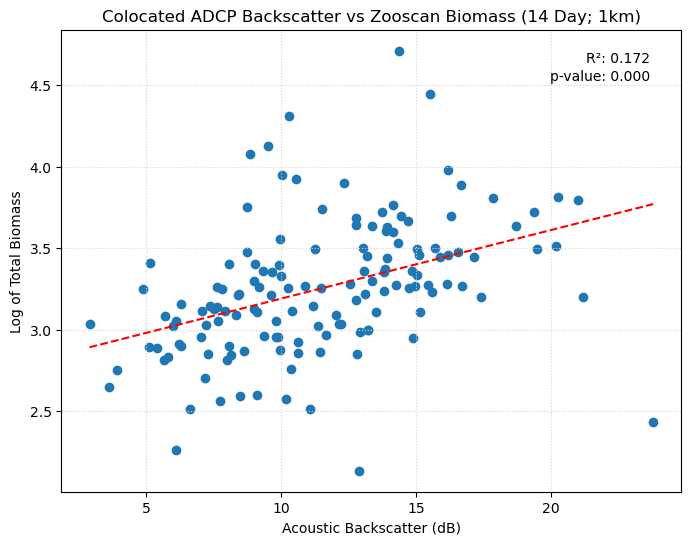

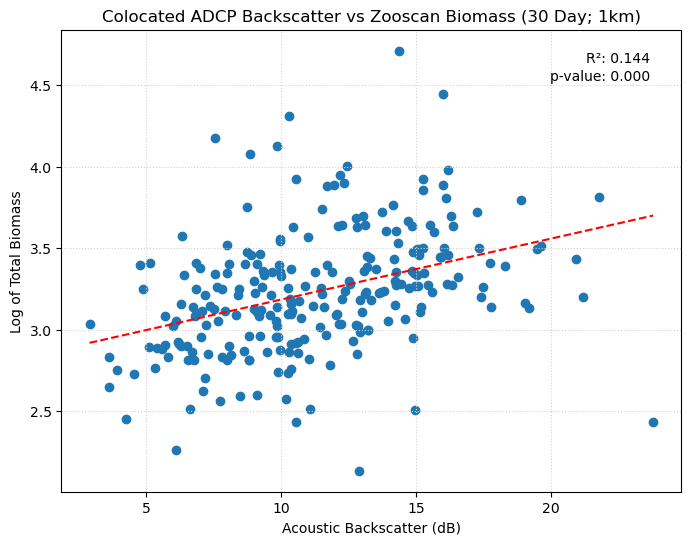

 20%|████████▍                                 | 1/5 [05:19<21:17, 319.30s/it]

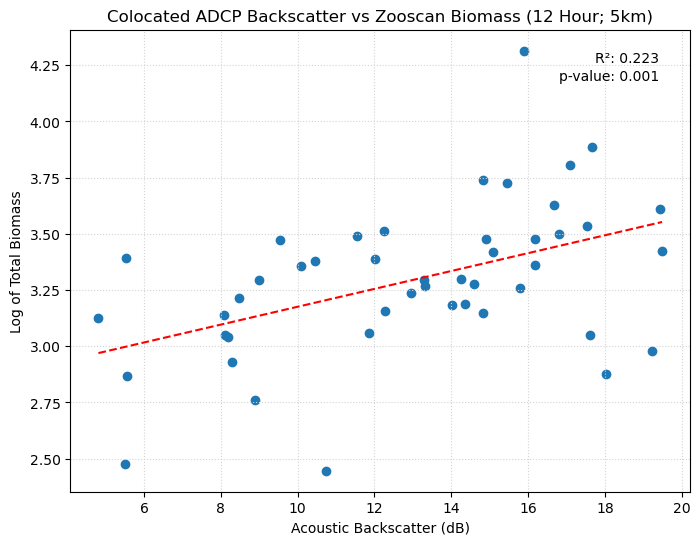

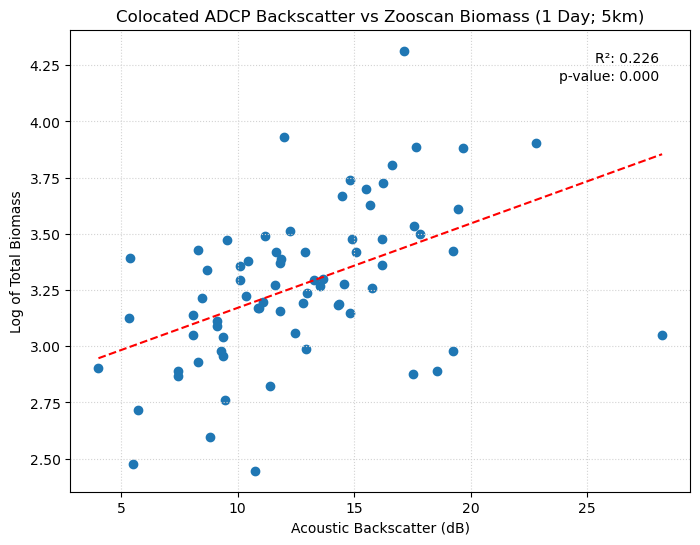

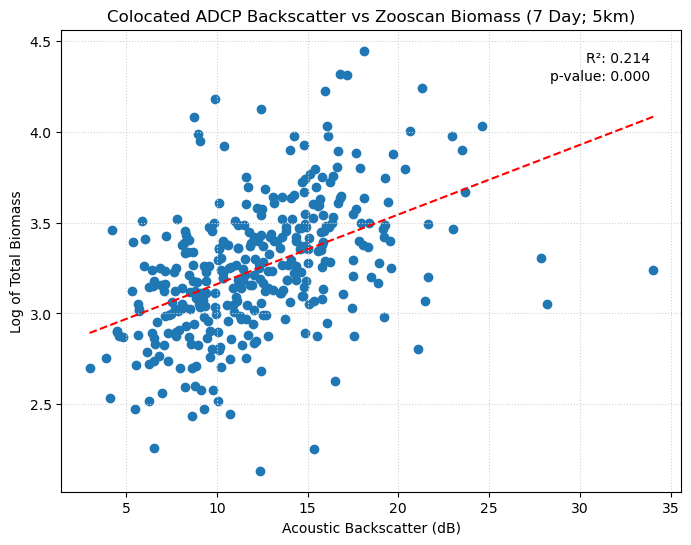

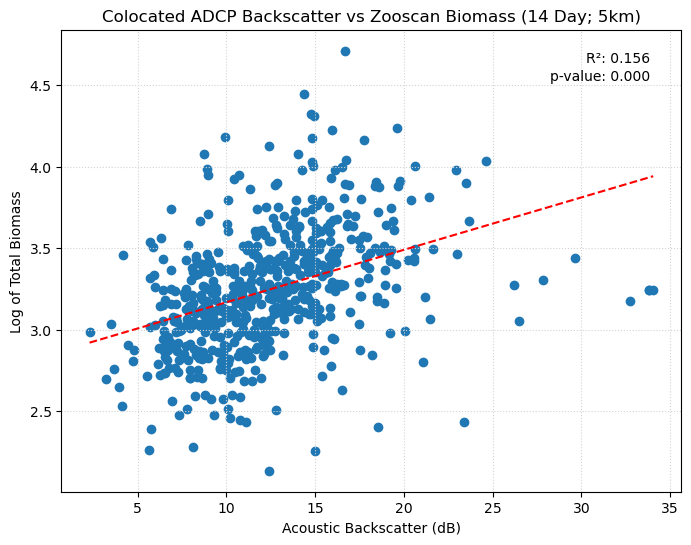

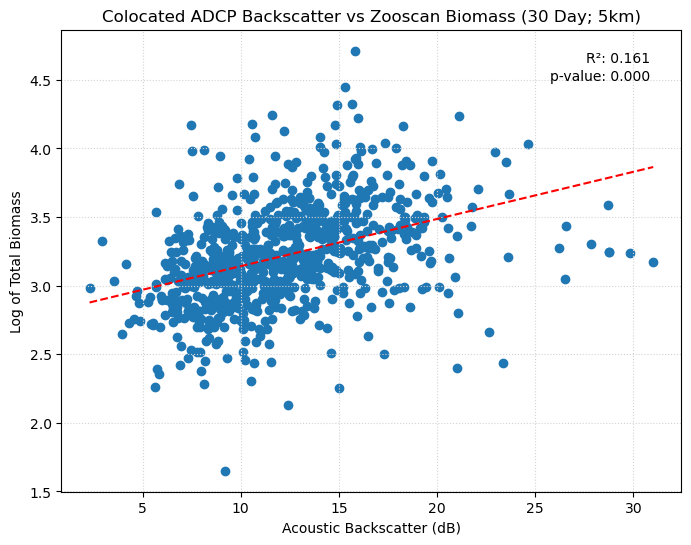

 40%|████████████████▊                         | 2/5 [10:51<16:21, 327.08s/it]

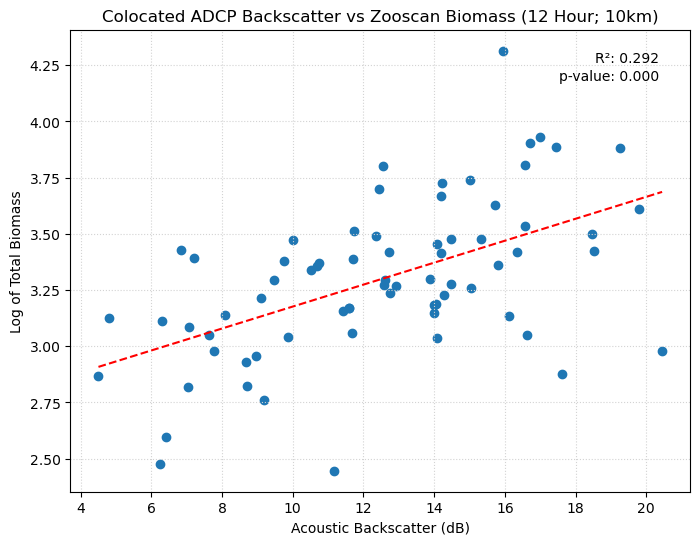

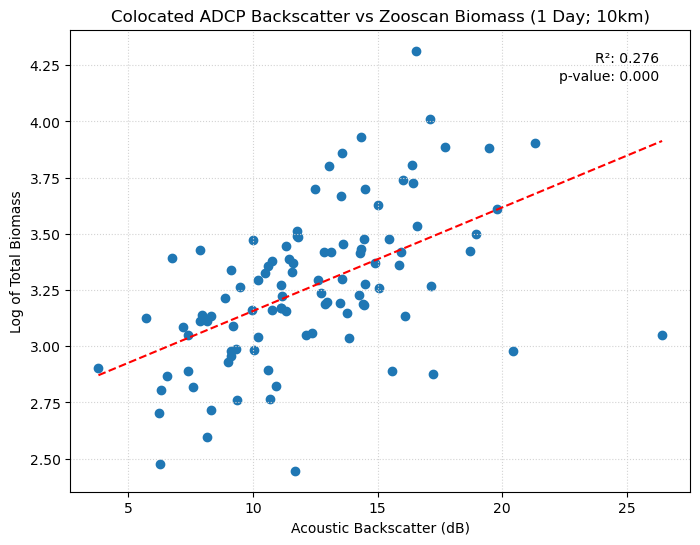

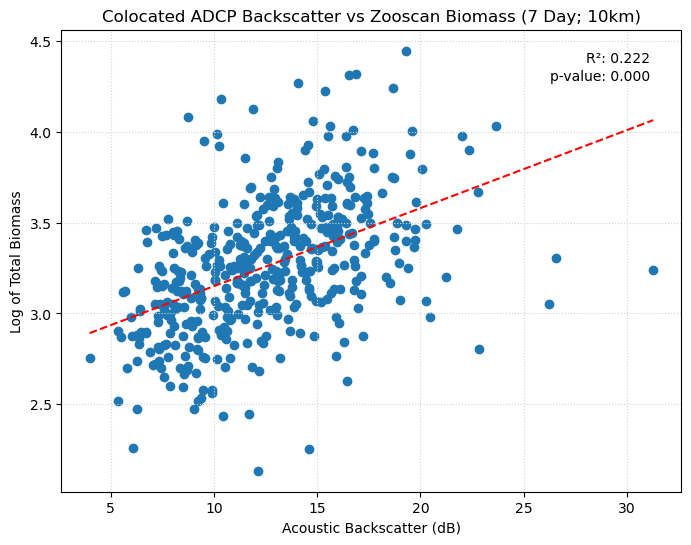

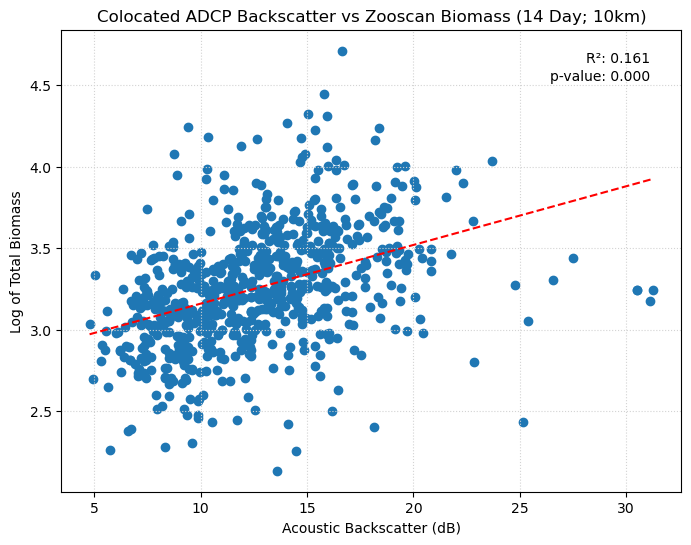

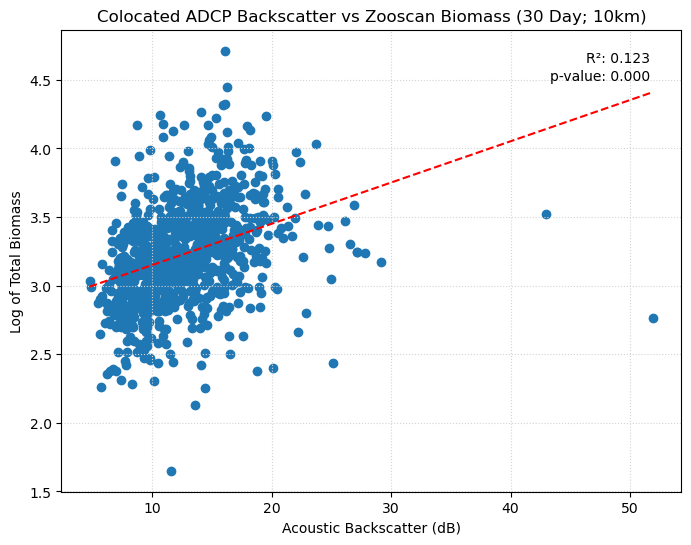

 60%|█████████████████████████▏                | 3/5 [16:32<11:06, 333.32s/it]

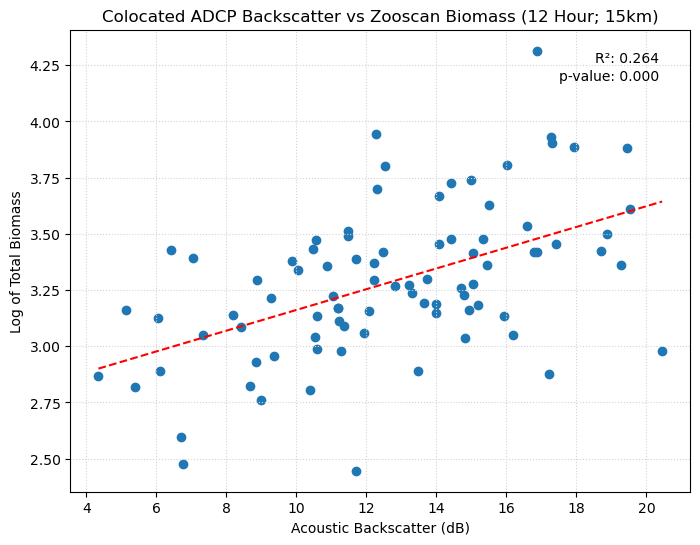

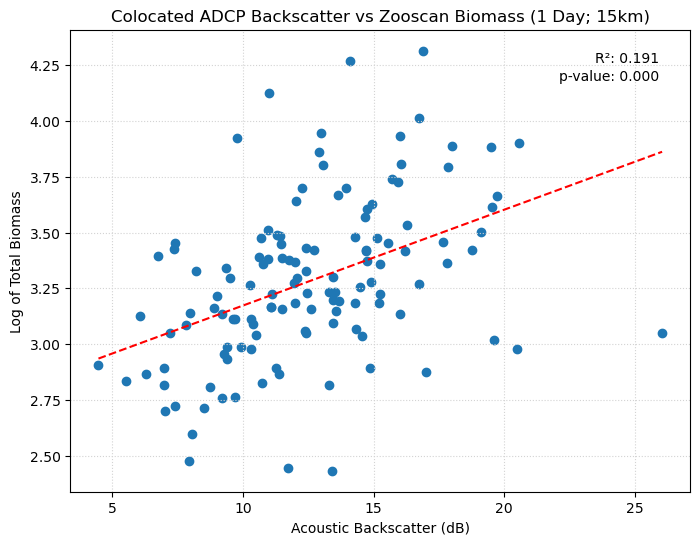

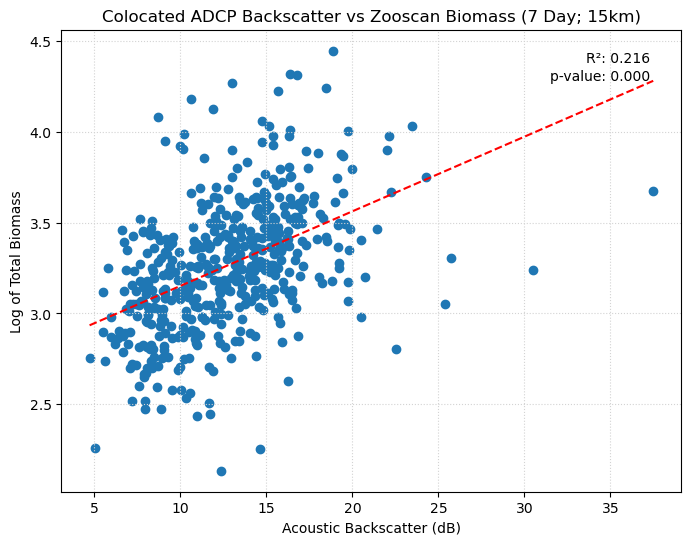

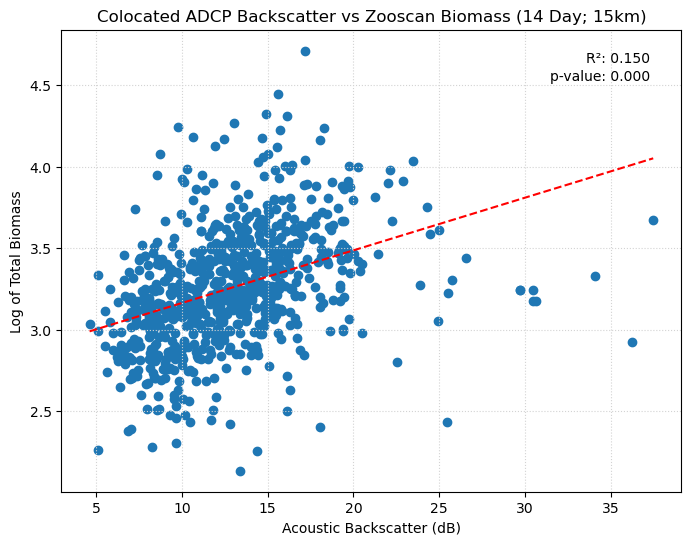

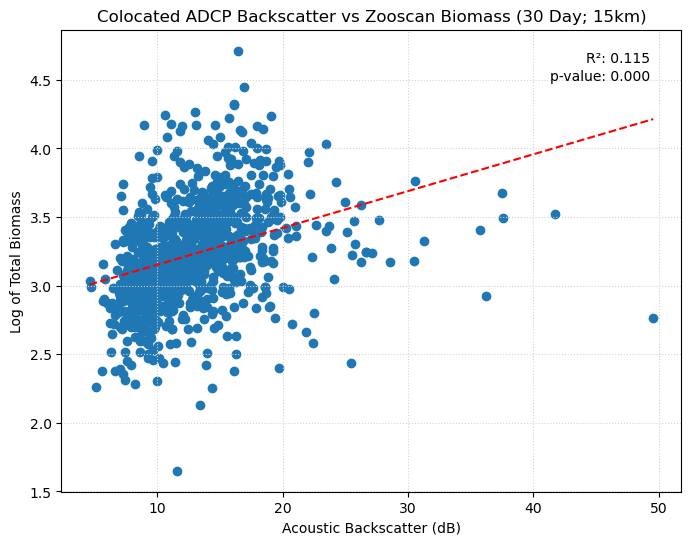

 80%|█████████████████████████████████▌        | 4/5 [22:27<05:41, 341.91s/it]

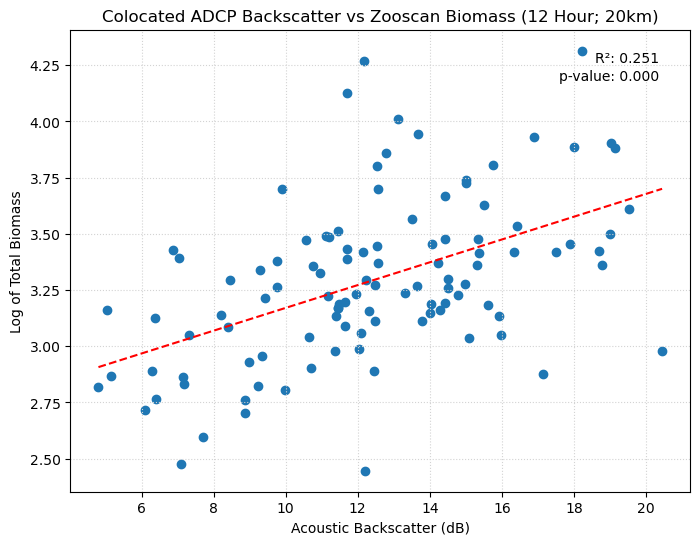

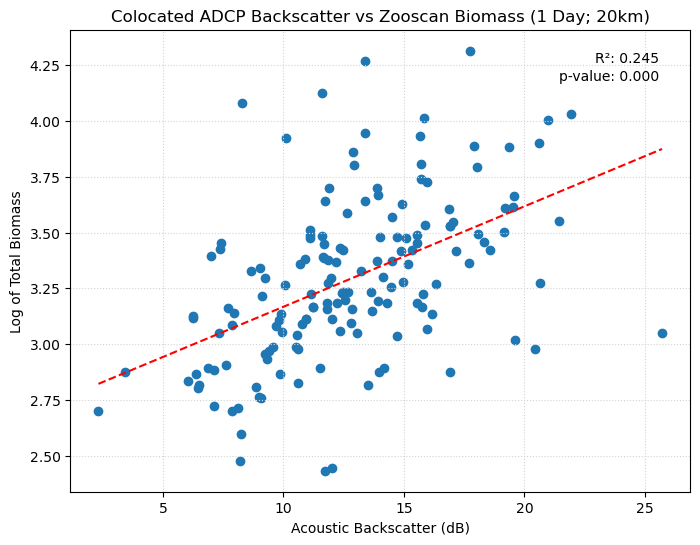

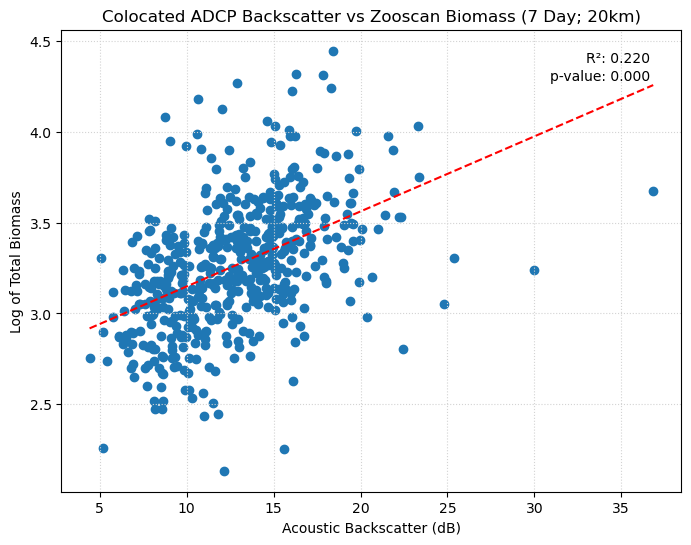

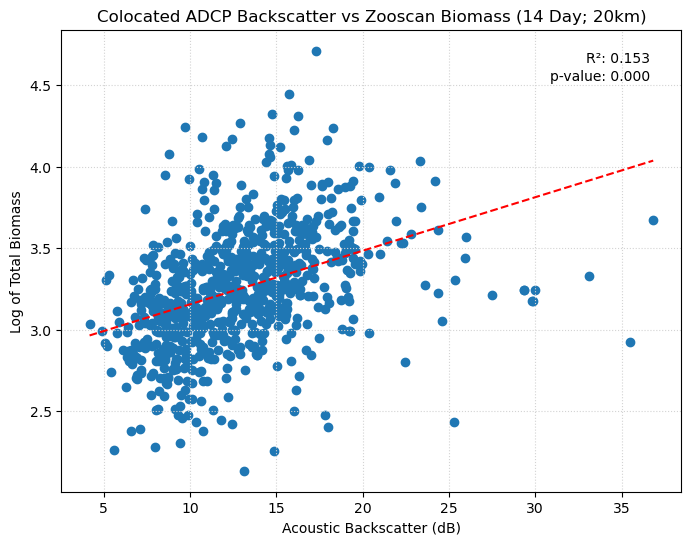

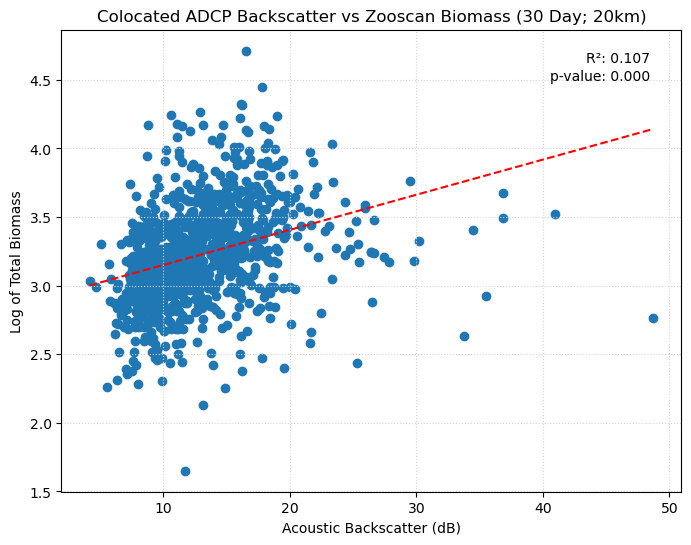

100%|██████████████████████████████████████████| 5/5 [28:48<00:00, 345.64s/it]


,Spatial,Temporal,RSquared,Slope,Intercept,N
0,1,0.5,0.487942,0.045276,2.807272,9
1,1,1.0,0.600863,0.071454,2.409854,13
2,1,7.0,0.273410,0.057011,2.596995,80
3,1,14.0,0.171813,0.042053,2.770040,154
4,1,30.0,0.144312,0.037393,2.810625,262
5,5,0.5,0.222709,0.039721,2.778373,46
6,5,1.0,0.225751,0.037541,2.795202,74
7,5,7.0,0.213910,0.038361,2.777827,364
8,5,14.0,0.156189,0.032198,2.845832,609
9,5,30.0,0.161042,0.034396,2.798282,839


In [3]:
###Spatially/Temporally Colocate Data
#instantiate lists
spatial_list = []
temporal_list = []
rsquared_list = []
intercept_list = []
slope_list = []
len_list = []

#instantiate variables
# spatial_buffer = 15 #15 km
# temporal_buffer = 1 #1 day

#loop through spatial and temporal scales
for spatial_buffer in tqdm.tqdm([1, 5, 10, 15, 20]):
    for temporal_buffer in [0.5, 1, 7, 14, 30]:
        
        ###Filter out ZooScan
        #open data and only look at data from 2008 to now
        zooscan = pd.read_csv('/Users/gammonkoval/Library/CloudStorage/GoogleDrive-gkoval@faralloninstitute.org/Shared drives/Commons/PROJECTS/2024_IOOS_GliderZooplankton/data/calcofi/ZooScan/ZooScan_combined.csv', parse_dates = ['DateTime'])
        zooscan = zooscan[zooscan['DateTime'].dt.year >= 2008]

        #remove duplicates and excess values
        zooscan = zooscan.drop_duplicates()
        zooscan.loc[(zooscan['season'] == 'Fall') & (zooscan['pyrosomes Estimated C Biomass (mgC m-2)'] > 10000), 'pyrosomes Estimated C Biomass (mgC m-2)'] = np.nan
        
        #filter out biomass columns
        zooscan['total_biomass'] = zooscan.drop('multiples Estimated C Biomass (mgC m-2)', axis = 1).filter(regex='Biomass').sum(axis = 1)
        # zooscan['total_biomass_log'] = np.log10(zooscan.drop('multiples Estimated C Biomass (mgC m-2)', axis = 1).filter(regex='Biomass') + 1).sum(axis = 1)
        zooscan['total_biomass_log'] = np.log10(zooscan['total_biomass'] + 1)
        
        #filter out copepod biomass columns
        zooscan['copepod_biomass'] = zooscan.drop('multiples Estimated C Biomass (mgC m-2)', axis = 1).filter(regex='Biomass').filter(regex = 'cope').sum(axis = 1)
        # zooscan['copepod_biomass_log'] = np.log10(zooscan.drop('multiples Estimated C Biomass (mgC m-2)', axis = 1).filter(regex='Biomass').filter(regex = 'cope') + 1).sum(axis = 1)
        zooscan['copepod_biomass_log'] = np.log10(zooscan['copepod_biomass'] + 1)
        
        #add inshore/offshore distinction
        # zooscan['Inshore_Offshore'] = np.where(zooscan['bathymetry'] > 2205, 'Offshore', 'Inshore')
        
        # zooscan['year'] = zooscan['DateTime'].dt.year
        # zooscan['month'] = zooscan['DateTime'].dt.month

        #create a copy of the data
        krill_comb = zooscan.reset_index(drop = True).copy()
        
        #open glider data
        files = ['/Users/gammonkoval/Library/CloudStorage/GoogleDrive-gkoval@faralloninstitute.org/Shared drives/Commons/PROJECTS/2024_IOOS_GliderZooplankton/data/glider/CUGN_line_80_clean.nc',
                 '/Users/gammonkoval/Library/CloudStorage/GoogleDrive-gkoval@faralloninstitute.org/Shared drives/Commons/PROJECTS/2024_IOOS_GliderZooplankton/data/glider/CUGN_line_90_clean.nc']
        
        # glider_sel = xr.Dataset()
        krill_colocate = pd.DataFrame()

        #loop through each glider file
        for file in files: 

            ###Process glider data
            #open the glider data
            glider = xr.open_dataset(file)
            glider.close()
            
            #calculate the standardization by mission
            glider_std = xr.Dataset()
            #loop through each glider mission
            for mission in np.unique(glider.mission.values):
                #select out the mission
                temp = glider.where(glider.mission == mission, drop = True)
            
                #calculate the 1%-tile value
                min_val = temp['acoustic_backscatter'].to_dataframe()['acoustic_backscatter'].quantile(0.01)

                #subtract the minimum value for each mission
                temp = temp.assign(acoustic_backscatter = temp.acoustic_backscatter - min_val)
                #set negative values to zero
                temp['acoustic_backscatter'] = xr.where(temp['acoustic_backscatter'] < 0, 0, temp['acoustic_backscatter'])

                #join together
                glider_std = xr.merge([glider_std, temp])
            
            glider = glider_std.copy()
            
            #convert to linear space and depth average
            glider = glider.where(glider.depth <= 210, drop = True)#.resample(time = '7D').mean(...)
            glider = glider.assign(little_sv = 10**(glider.acoustic_backscatter/10))
            glider = glider.mean(dim = 'depth')
            
            #convert glider to geodataframe
            glider_points = glider[['lat', 'lon', 'time']].to_dataframe()
            glider_points = gpd.GeoDataFrame(glider_points, geometry=gpd.points_from_xy(glider_points.lon, glider_points.lat), crs="EPSG:4326")
            
            #loop through each krill point
            # for i in tqdm.tqdm(range(len(krill_comb))):
            for i in range(len(krill_comb)):
                #select out one net survey and localize the data
                temp = krill_comb.loc[[i]]
                temp['DateTime'] = temp['DateTime'].dt.tz_localize('US/Pacific', ambiguous = True).dt.tz_convert('UTC')
            
                #convert to geodataframe
                temp = gpd.GeoDataFrame(temp, geometry=gpd.points_from_xy(temp.longitude, temp.latitude), crs="EPSG:4326")
                
                #add buffer (in km)
                temp['geometry'] = temp.to_crs('epsg:32611').buffer(spatial_buffer * 1000).to_crs('epsg:4326')
                
                #select glider points within line polygon
                glider_points_sel = gpd.sjoin(glider_points, temp, predicate = 'within')

                #check how many points are returned
                if len(glider_points_sel.index) != 0:
                
                    #select out matching glider points
                    glider_temp = glider.where(glider.profile.isin(glider_points_sel.index), drop = True)
                    
                    #select points within a time period
                    glider_temp = glider_temp.where((glider_temp.time >= temp['DateTime'].values[0] - pd.Timedelta(temporal_buffer, unit = 'days')) &
                                                    (glider_temp.time <= temp['DateTime'].values[0] + pd.Timedelta(temporal_buffer, unit = 'days')), drop = True)

                    #check how many points are returned
                    if len(glider_temp.acoustic_backscatter.values) != 0:
                        
                        #add in matching krill point
                        # glider_temp = glider_temp.assign_coords(zooscan = temp.index.values[0])
                
                        # glider_sel = xr.merge([glider_sel, glider_temp])
        
                        # glider_temp = glider_temp.mean(...)
                        # glider_temp = glider_temp.assign(big_sv = 10*np.log10(glider_temp.little_sv))
                        # glider_temp = glider_temp['big_sv'].to_dataframe().reset_index()#.groupby('depth').mean().reset_index()

                        #convert to log-space
                        # glider_temp = glider_temp.little_sv.to_dataframe().reset_index().mean(axis = 0).to_frame().T
                        glider_temp = glider_temp.to_dataframe().reset_index().mean(axis = 0).to_frame().T
                        glider_temp['big_sv'] = 10*np.log10(glider_temp.little_sv.values[0])
                
                        #rename glider temp values
                        glider_temp = glider_temp.rename({'lat':'glider_lat', 'lon':'glider_lon', 'time':'glider_time'}, axis = 1)

                        #add columns
                        krill_temp = pd.DataFrame(np.repeat(temp.values, len(glider_temp), axis=0))
                        krill_temp.columns = temp.columns

                        #join together krill and glider data
                        krill_temp = krill_temp.join(glider_temp, rsuffix='_glider', )#[['glider_lat', 'glider_lon', 'glider_time', 'profile', 'big_sv']])
                        krill_colocate = pd.concat([krill_colocate, krill_temp])
                        krill_colocate = krill_colocate.drop('geometry', axis = 1) 

        #save spatial/temporal buffer output
        krill_colocate.to_csv('./spatial_temporal_testing/Backscatter_vs_Biomass_'+str(temporal_buffer)+'day_'+str(spatial_buffer)+'km.csv', index = False)
        
        ###Run regression
        #select out x and y
        X = krill_colocate['big_sv']
        Y = krill_colocate['total_biomass_log'].astype(float)
        
        #add a condstant for the regression
        X = sm.add_constant(X)
        
        #run the model
        model = sm.OLS(Y, X, missing = 'drop').fit()
        
        #you can also extract out some of the necessary values
        slope = model.params[1]
        intercept = model.params[0]
        p_val = model.pvalues[1]

        #extract parameters
        r_squared = model.rsquared
        #confidence_intervals = model.conf_int(0.05)
        _, upper,lower = wls_prediction_std(model)
        
        #use the output to calculate the predicted values
        y_pred = slope * X['big_sv'] + intercept
        
        #join the predicted values back to the full data
        krill_colocate['pred'] = y_pred
        
        #add the upper and lower bounds
        # krill_colocate['upper_ci'] = upper
        # krill_colocate['lower_ci'] = lower
        
        #look at the model output
        # model.summary()

        ###Plot regression
        #plot the data the best fit line
        plt.figure(figsize = (8, 6))
        plt.scatter(krill_colocate['big_sv'], krill_colocate['total_biomass_log'])
        
        #add the regression line
        plt.plot(krill_colocate.sort_values('pred')['big_sv'], krill_colocate.sort_values('pred')['pred'], c = 'red', linestyle = 'dashed')
        
        #add the rsquared and p-value
        plt.text(0.95, 0.93, u"R\u00b2: {:0.3f}".format(r_squared), horizontalalignment = 'right', transform=plt.gca().transAxes)
        plt.text(0.95, 0.89, u"p-value: {:0.3f}".format(p_val), horizontalalignment = 'right', transform=plt.gca().transAxes)
        plt.grid(color = 'lightgrey', linestyle = 'dotted')
        
        #add labels and title
        plt.xlabel('Acoustic Backscatter (dB)')
        plt.ylabel('Log of Total Biomass')
        if temporal_buffer == 0.5:
            plt.title("Colocated ADCP Backscatter vs Zooscan Biomass (12 Hour; "+str(spatial_buffer)+"km)")
        else:
            plt.title("Colocated ADCP Backscatter vs Zooscan Biomass ("+str(temporal_buffer)+" Day; "+str(spatial_buffer)+"km)")
        plt.savefig('./spatial_temporal_testing/Backscatter_vs_Biomass_'+str(temporal_buffer)+'day_'+str(spatial_buffer)+'km.png', bbox_inches = 'tight', dpi = 300)
        plt.show()

        #add values to lists
        spatial_list.append(spatial_buffer)
        temporal_list.append(temporal_buffer)
        rsquared_list.append(r_squared)
        intercept_list.append(intercept)
        slope_list.append(slope)
        len_list.append(len(krill_colocate))

#create and save dataframe of results
results = pd.DataFrame({'Spatial':spatial_list, 'Temporal':temporal_list, 'RSquared':rsquared_list, 'Slope':slope_list, 'Intercept':intercept_list, 'N':len_list})
results.to_csv('/Users/gammonkoval/Documents/GitHub/gammon_sol/IRA_Krill/spatial_temporal_testing/Backscatter_vs_Biomass_RegressionResults.csv')
results

In [184]:
#look at number of observations for each spatial scale
results.pivot(index='Temporal', columns='Spatial', values='N')

Spatial,1,5,10,15,20
Temporal,,,,,
12,9,46,72,87,110


In [185]:
#look at r-squared values for each spatial scale
results.pivot(index='Temporal', columns='Spatial', values='RSquared')

Spatial,1,5,10,15,20
Temporal,,,,,
12,0.487942,0.222709,0.291593,0.263726,0.251455


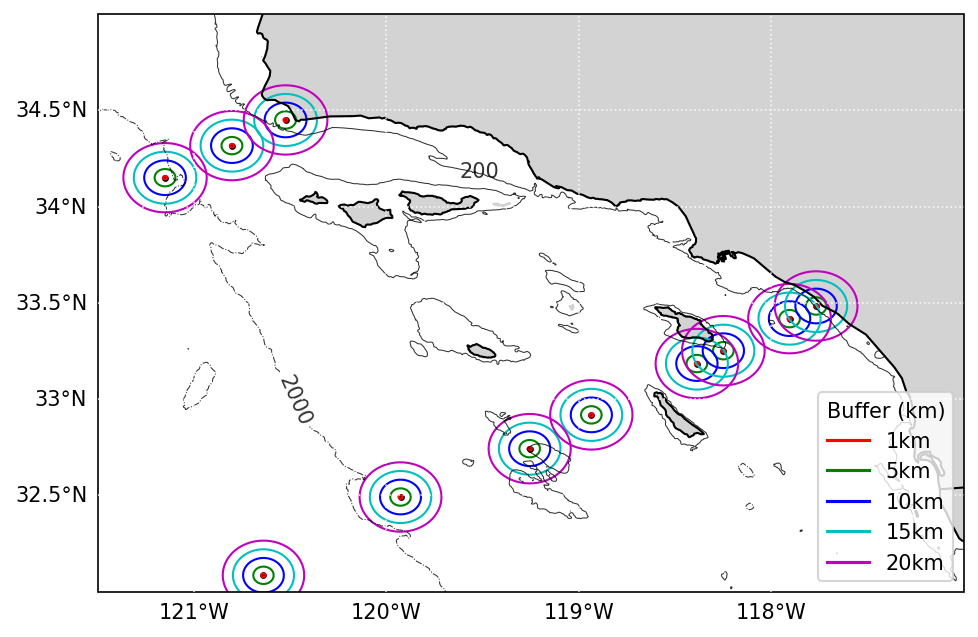

In [223]:
###Glider Map for spatial scales
#loop through glider files
files = ['/Users/gammonkoval/Library/CloudStorage/GoogleDrive-gkoval@faralloninstitute.org/Shared drives/Commons/PROJECTS/2024_IOOS_GliderZooplankton/data/glider/CUGN_line_80_clean.nc',
         '/Users/gammonkoval/Library/CloudStorage/GoogleDrive-gkoval@faralloninstitute.org/Shared drives/Commons/PROJECTS/2024_IOOS_GliderZooplankton/data/glider/CUGN_line_90_clean.nc']

#open depth data
depth = xr.open_dataset('./data/GEBCO_18_Oct_2024_72503139a832/gebco_2024_n35.0_s30.0_w-125.0_e-117.0.nc')
depth.close()
depth['elevation_inv'] = depth.elevation * -1
depth['elevation_inv'] = xr.where(depth.elevation_inv < 0, np.nan, depth.elevation_inv)

# latr = [30, 35] 
# lonr = [-125, -117] 

#set map boundaries
latr = [32, 35] 
lonr = [-121.5, -117] 

# Select a region of our data, giving it a margin
margin = 0.0
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]-margin,lonr[1]+margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(10,5), dpi = 150) 
ax = plt.axes(projection=ccrs.PlateCarree()) 

#add cartopy features
ax.coastlines(resolution='10m',linewidth=1,color='black', zorder = 3) 
ax.add_feature(cfeature.LAND, color='lightgrey', alpha=1)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
# ax.set_xticks(np.round([*np.arange(-180, 180,1)],0), crs=ccrs.PlateCarree()) 
# ax.set_yticks(np.round([*np.arange(-90, 90)],1), crs=ccrs.PlateCarree()) 
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
gl = ax.gridlines(linestyle = 'dotted', color = 'white', alpha = 0.8, zorder = 5, draw_labels=True, y_inline = False)
gl.xlabels_top = False
gl.ylabels_right = False
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())

#open CalCOFI stations and plot
temp = gpd.read_file('/Users/gammonkoval/Downloads/CalCOFI_113StationMap.kml')
temp['Station'] = temp['Name'].str.split(' ').str[0]
temp['Station'] = temp['Station'].astype(float)

#filter out CalCOFI stations for only line 80 and 90
temp = temp[(temp['Name'].str.contains("80.0")) | (temp['Name'].str.contains("90.0"))]
temp = temp[~(temp['Name'].str.contains("SCCOOS")) & ~(temp['Name'].str.contains("93.3")) & ~(temp['Name'].str.contains("86.7"))]
temp = temp[~(temp['Name'].str.contains("83.3")) & ~(temp['Name'].str.contains("76.7")) & ~(temp['Name'].str.contains("73.3"))]
temp = temp[~(temp['Name'].str.contains("70.0 90.0")) & ~(temp['Name'].str.contains("70.0 80.0"))]

temp.plot(ax = ax, c = 'k', markersize = 5)

#add buffers for CalCOFI stations
temp.to_crs('epsg:32611').buffer(1 * 1000).to_crs('epsg:4326').plot(ax = ax, facecolor = 'None', edgecolor = 'r', lw = 1)
temp.to_crs('epsg:32611').buffer(5 * 1000).to_crs('epsg:4326').plot(ax = ax, facecolor = 'None', edgecolor = 'g', lw = 1)
temp.to_crs('epsg:32611').buffer(10 * 1000).to_crs('epsg:4326').plot(ax = ax, facecolor = 'None', edgecolor = 'b', lw = 1)
temp.to_crs('epsg:32611').buffer(15 * 1000).to_crs('epsg:4326').plot(ax = ax, facecolor = 'None', edgecolor = 'c', lw = 1)
temp.to_crs('epsg:32611').buffer(20 * 1000).to_crs('epsg:4326').plot(ax = ax, facecolor = 'None', edgecolor = 'm', lw = 1)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend
line1 = Line2D([0], [0], label='1km', color='r')
line2 = Line2D([0], [0], label='5km', color='g')
line3 = Line2D([0], [0], label='10km', color='b')
line4 = Line2D([0], [0], label='15km', color='c')
line5 = Line2D([0], [0], label='20km', color='m')

# add manual symbols to auto legend
handles.extend([line1, line2, line3, line4, line5])

#add legend
plt.legend(handles=handles, loc = 'lower right', title = 'Buffer (km)')

#add bathymetry line
positions = [(-119.5, 34.25)]
CS = depth.where((depth.elevation >= -400) & (depth.elevation <= 0), drop = True).elevation_inv.plot.contour(x = 'lon', ax = ax, colors = 'k', levels = 1, linestyles = 'solid', transform = ccrs.PlateCarree(), linewidths = 0.5, alpha = 0.8)
ax.clabel(CS, CS.levels, inline=True, fontsize=10, manual = positions)

positions = [(-120.5, 33)]
CS = depth.where((depth.elevation >= -4000) & (depth.elevation <= 0), drop = True).elevation_inv.plot.contour(x = 'lon', ax = ax, colors = 'k', levels = 1, linestyles = 'dashdot', transform = ccrs.PlateCarree(), linewidths = 0.5, alpha = 0.8)
ax.clabel(CS, CS.levels, inline=True, fontsize=10, manual = positions)

# plt.title('CUGN Glider Tracks with CalCOFI Stations')
plt.xlabel(None)
plt.ylabel(None)
plt.gca().set_aspect('equal')
